In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 130
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.libqsturng
import math
import statsmodels.stats.outliers_influence as sso
import statsmodels
import statistics
from scipy.optimize import curve_fit

In [2]:
def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

In [3]:
def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    #print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

In [4]:
def SI_MA(y_v, n):
    y_v_MA_a = np.zeros(len(y_v))
    y_v_MA_a[:] = np.nan
    mvlen = n
    if n % 2 == 0:
        halfwin = int(mvlen / 2)
        y_v_MA_ta = np.zeros(len(y_v))
        for i in range(halfwin, len(y_v) - halfwin + 1):
            y_v_MA_ta[i] = np.mean(y_v[(i-halfwin): (i+halfwin)])
        for ii in range(halfwin, len(y_v) - halfwin):
            y_v_MA_a[ii] = np.mean(y_v_MA_ta[(ii): (ii+2)])
    else:
        halfwin = int((mvlen - 1) / 2)
        for i in range(halfwin, len(y_v) - halfwin):
            y_v_MA_a[i] = np.mean(y_v[(i-halfwin): (i+halfwin+1)])
    SI_MA_a = np.zeros(len(y_v))
    SI_MA_a[:] = np.nan
    SI_MA_a = y_v / y_v_MA_a    
    SI_id_s = np.arange(1,len(y_v)+1)
    SI_id = SI_id_s - np.floor(SI_id_s / n) * n
    SI_id[np.where((SI_id[:] == 0))] = n
    SI_MA_a_df = pd.DataFrame({'SIMA': SI_MA_a, 'SIid': SI_id})
    SI_MA_u = np.zeros(n)
    for j in range(1,n+1):
        SI_MA_u[j-1] = SI_MA_a_df['SIMA'][SI_MA_a_df['SIid'] == j].dropna().mean()  
    SI_MA = SI_MA_u / sum(SI_MA_u) * n
    print('Seasonal Index:', SI_MA ) 
    y_v_SI_MA = np.zeros(len(y_v))
    DSI_y_v = np.zeros(len(y_v))
    for k in range(0,len(y_v)):
        Idd = int(SI_MA_a_df['SIid'][k] - 1)
        y_v_SI_MA[k] = SI_MA[Idd]
        DSI_y_v[k] = y_v[k] / SI_MA[Idd]
    print('Deseasonalized Data:', DSI_y_v)
    SI_MA_result_a = np.array([SI_MA_a_df['SIid'], y_v_SI_MA, y_v, DSI_y_v])
    SI_MA_result_df = pd.DataFrame(SI_MA_result_a.T, columns = ['SID', 'SeaIdx', 'orig', 'Des_D'])
    return {"ma_ind":SI_MA, "SI_MA_res":SI_MA_result_df}

In [5]:
#讀取資料集
df1 = pd.read_csv('excel/110.csv')
print('Head of dataset:')
display(df1.head())
print("Tail of dataset:")
display(df1.tail())

Head of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
0,1月1日,168.20,318.524,0.0,"1,109,556","1,289,556","-180,000","2,475,360","3,764,916"
1,1月2日,168.18,318.419,3.8,"974,520","614,520","360,000","2,221,200","2,835,720"
2,1月3日,168.22,318.741,0.4,"817,460","458,460","359,000","2,328,120","2,786,580"
3,1月4日,168.23,318.887,16.1,"1,168,992","1,168,992",0,"2,098,080","3,267,072"
4,1月5日,168.30,319.450,20.7,"2,306,772","2,126,772","180,000","2,324,880","4,451,652"


Tail of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
360,12月27日,168.07,317.416,13.6,"4,729,660","4,101,660","628,000","2,787,480","6,889,140"
361,12月28日,168.15,318.109,1.1,"3,473,152","2,575,152","898,000","2,765,520","5,340,672"
362,12月29日,168.22,318.749,0.4,"2,310,048","2,130,048","180,000","2,468,160","4,598,208"
363,12月30日,168.20,318.502,0.2,"1,857,808","2,396,808","-539,000","2,243,520","4,640,328"
364,12月31日,168.16,318.232,1.4,"1,244,456","615,456","629,000","2,050,560","2,666,016"


In [6]:
for i in range(365):
    df1['水庫進流量/立方公尺'][i] = int(df1['水庫進流量/立方公尺'][i].replace(",",""))

<ipython-input-6-04087e631c7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['水庫進流量/立方公尺'][i] = int(df1['水庫進流量/立方公尺'][i].replace(",",""))


In [7]:
mean_1 = np.zeros(12)
print(mean_1)
for i in range(1, 13):
    #print(i)
    if (i == 1) or (i == 2): 
        #print(i)
        filt = (df1['日期'].str.contains(str(i)+'月', na=False)) & ~ (df1['日期'].str.contains('1'+str(i)+'月', na=False))
    else:
        filt = (df1['日期'].str.contains(str(i)+'月', na=False))
    df = df1.loc[filt, ['日期', '水庫進流量/立方公尺']]
    mean_1[i-1] = np.mean(df['水庫進流量/立方公尺'])

print(mean_1)
#print(df['水庫進流量/立方公尺'])
#print(df1.loc[filt, ['日期', '水庫進流量/立方公尺']])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1916696.64516129 1488259.28571429  851123.87096774  828801.2
 1036746.96774194 3506656.33333333 3585141.41935484 3037998.70967742
 1716383.86666667 5502067.87096774 2087082.53333333 2244125.80645161]


In [8]:
#讀取資料集
df2 = pd.read_csv('excel/109.csv')
print('Head of dataset:')
display(df2.head())
print("Tail of dataset:")
display(df2.tail())

Head of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
0,1月1日,167.10,308.766,2.1,"2,416,420","462,420","1,954,000","2,206,080","2,668,500"
1,1月2日,167.27,310.273,0.0,"1,718,880","740,880","978,000","1,889,280","2,630,160"
2,1月3日,167.35,310.918,0.0,"1,391,012","1,302,012","89,000","1,715,400","3,017,412"
3,1月4日,167.34,310.844,0.1,"1,002,260","1,180,260","-178,000","1,586,160","2,766,420"
4,1月5日,167.31,310.625,0.2,"1,018,292","1,463,292","-445,000","1,481,040","2,944,332"


Tail of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
361,12月27日,168.44,320.737,1.1,"2,568,852","2,118,852","450,000","3,963,600","6,082,452"
362,12月28日,168.46,320.868,2.2,"1,949,832","2,129,832","-180,000","3,466,800","5,596,632"
363,12月29日,168.32,319.622,0.4,"1,730,160","3,260,160","-1,530,000","3,146,400","6,406,560"
364,12月30日,168.16,318.161,10.6,"1,869,816","3,216,816","-1,347,000","2,921,040","6,137,856"
365,12月31日,168.11,317.802,0.0,"988,000",0,"988,000","2,761,200","2,761,200"


In [9]:
for i in range(366):
    df2['水庫進流量/立方公尺'][i] = int(df2['水庫進流量/立方公尺'][i].replace(",",""))

<ipython-input-9-3ac53e395283>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['水庫進流量/立方公尺'][i] = int(df2['水庫進流量/立方公尺'][i].replace(",",""))


In [10]:
mean_2 = np.zeros(12)
print(mean_2)
for i in range(1, 13):
    #print(i)
    if (i == 1) or (i == 2): 
        #print(i)
        filt = (df2['日期'].str.contains(str(i)+'月', na=False)) & ~ (df2['日期'].str.contains('1'+str(i)+'月', na=False))
    else:
        filt = (df2['日期'].str.contains(str(i)+'月', na=False))
    df = df2.loc[filt, ['日期', '水庫進流量/立方公尺']]
    mean_2[i-1] = np.mean(df['水庫進流量/立方公尺'])

print(mean_2)
#print(df['水庫進流量/立方公尺'])
#print(df1.loc[filt, ['日期', '水庫進流量/立方公尺']])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 968462.19354839  998404.         1268142.19354839 1290393.2
 3471635.61290323 1511104.         1085650.06451613  844325.80645161
  982157.2        3595804.77419355 2568258.4        6063531.61290323]


In [11]:
#讀取資料集
df3 = pd.read_csv('excel/108.csv')
print('Head of dataset:')
display(df3.head())
print("Tail of dataset:")
display(df3.tail())

Head of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
0,1月1日,167.64,313.631,18.9,"7,543,380","3,796,380","3,747,000","6,307,200","10,103,580"
1,1月2日,167.76,314.587,16.8,"6,572,620","6,661,620","-89,000","6,316,200","12,977,820"
2,1月3日,167.77,314.699,18.4,"7,019,088","6,662,088","357,000","6,793,200","13,455,288"
3,1月4日,167.84,315.378,6.7,"7,374,848","6,658,848","716,000","6,391,800","13,050,648"
4,1月5日,167.75,314.506,1.0,"4,338,772","6,662,772","-2,324,000","5,221,800","11,884,572"


Tail of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
360,12月27日,166.98,307.530,3.1,"855,940","1,742,940","-887,000","1,409,760","3,152,700"
361,12月28日,166.90,306.643,0.7,"700,700","1,586,700","-886,000","1,346,400","2,933,100"
362,12月29日,166.77,305.816,14.3,"832,740","1,186,740","-354,000","1,440,360","2,627,100"
363,12月30日,166.74,305.569,19.1,"1,129,728","1,306,728","-177,000","1,550,520","2,857,248"
364,12月31日,166.82,306.319,17.1,"2,393,000",0,"2,393,000","2,192,400","2,192,400"


In [12]:
for i in range(365):
    df3['水庫進流量/立方公尺'][i] = int(df3['水庫進流量/立方公尺'][i].replace(",",""))

<ipython-input-12-93d927d232e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['水庫進流量/立方公尺'][i] = int(df3['水庫進流量/立方公尺'][i].replace(",",""))


In [13]:
mean_3 = np.zeros(12)
print(mean_3)
for i in range(1, 13):
    #print(i)
    if (i == 1) or (i == 2): 
        #print(i)
        filt = (df3['日期'].str.contains(str(i)+'月', na=False)) & ~ (df3['日期'].str.contains('1'+str(i)+'月', na=False))
    else:
        filt = (df3['日期'].str.contains(str(i)+'月', na=False))
    df = df3.loc[filt, ['日期', '水庫進流量/立方公尺']]
    mean_3[i-1] = np.mean(df['水庫進流量/立方公尺'])

print(mean_3)
#print(df['水庫進流量/立方公尺'])
#print(df1.loc[filt, ['日期', '水庫進流量/立方公尺']])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2683037.03225806  881138.28571429 1405088.         1096763.6
 2673795.74193548 2917327.2        1811000.38709677 3228924.90322581
 4737023.46666667 2757452.25806452 1526410.26666667 2103162.06451613]


In [14]:
mean = np.concatenate((mean_1, mean_2, mean_3), axis=None)
#print(mean)

df_1 = pd.DataFrame(mean, columns = ['mean'])
print('Head of dataset:')
display(df_1.head())
print("Tail of dataset:")
display(df_1.tail())

Head of dataset:


,mean
0,1.916697e+06
1,1.488259e+06
2,8.511239e+05
3,8.288012e+05
4,1.036747e+06


Tail of dataset:


,mean
31,3.228925e+06
32,4.737023e+06
33,2.757452e+06
34,1.526410e+06
35,2.103162e+06


In [15]:
t = range(1,df_1.shape[0]+1)
df_1.insert(0, 'Period', t)
#display(df_1)

In [16]:
t = range(0,df_1.shape[0])
df_1.insert(2, 't', t)
#display(df_1)

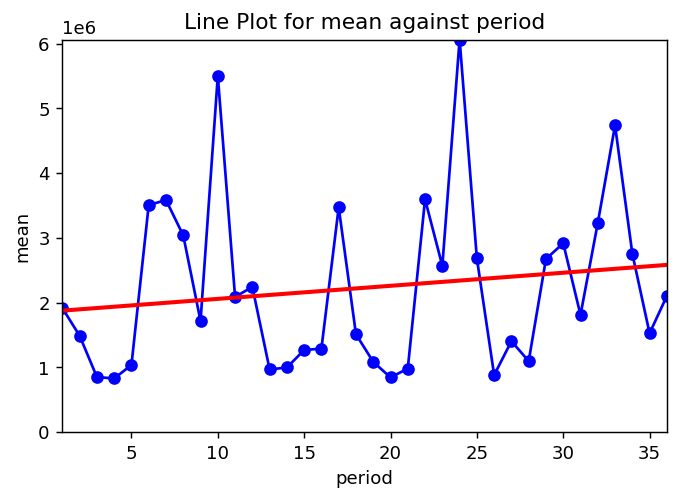

In [17]:
plt.scatter(df_1['Period'], df_1['mean'], color='blue')
plt.plot(df_1['Period'], df_1['mean'], color='blue')
sns.regplot(x = df_1['Period'], y = df_1['mean'], data = df_1, color = 'r', ci = None, scatter = False)
plt.ylim(0, max(df_1['mean'])+5)
plt.title('Line Plot for mean against period')
plt.xlabel('period')
plt.ylabel('mean')
plt.show()

Seasonal Index: [0.78769787 0.4195905  0.5831926  0.54425336 1.46221837 0.95590864
 1.01064524 0.85078531 0.59279912 1.98044494 1.00576715 1.80669691]
Deseasonalized Data: [2433289.09843188 3546932.7776995  1459421.59434323 1522822.38715516
  709023.35273126 3668401.11760194 3547378.72971834 3570817.08168751
 2895388.67829733 2778197.84343567 2075115.0426042  1242115.2628453
 1229484.33376447 2379472.385611   2174482.66356103 2370942.09466973
 2374225.14683892 1580803.78442544 1074214.79275283  992407.601288
 1656812.84496744 1815655.00523771 2553531.81008267 3356142.12958987
 3406175.29527381 2099995.81207784 2409303.55627432 2015171.02472449
 1828588.53746614 3051889.13414779 1791924.9204554  3795228.80085396
 7990942.10833612 1392339.77049873 1517657.71355799 1164092.35750618]
[0.78769787 0.4195905  0.5831926  0.54425336 1.46221837 0.95590864
 1.01064524 0.85078531 0.59279912 1.98044494 1.00576715 1.80669691]


,SID,SeaIdx,orig,Des_D
0,1.0,0.787698,1.916697e+06,2.433289e+06
1,2.0,0.419590,1.488259e+06,3.546933e+06
2,3.0,0.583193,8.511239e+05,1.459422e+06
3,4.0,0.544253,8.288012e+05,1.522822e+06
4,5.0,1.462218,1.036747e+06,7.090234e+05
5,6.0,0.955909,3.506656e+06,3.668401e+06
6,7.0,1.010645,3.585141e+06,3.547379e+06
7,8.0,0.850785,3.037999e+06,3.570817e+06
8,9.0,0.592799,1.716384e+06,2.895389e+06
9,10.0,1.980445,5.502068e+06,2.778198e+06


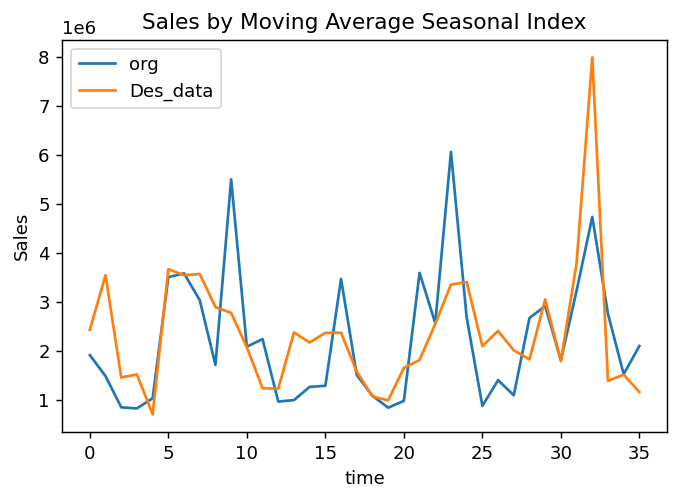

In [18]:
df_1_ts3_MA_S_result = pd.DataFrame(columns=["ma_ind", "SI_MA_res"])
df_1_ts3_MA_S_result = SI_MA(df_1['mean'], 12)
df_1_ts3_MA_Idx = df_1_ts3_MA_S_result["ma_ind"]
print(df_1_ts3_MA_Idx)
df_1_ts3_MA_Result = df_1_ts3_MA_S_result["SI_MA_res"]
display(df_1_ts3_MA_Result)
plt.plot(df_1['t'], df_1_ts3_MA_Result['orig'])
plt.plot(df_1['t'], df_1_ts3_MA_Result['Des_D'])
plt.legend(labels=['org', 'Des_data'])
plt.xlabel('time')
plt.ylabel('Sales')
plt.title('Sales by Moving Average Seasonal Index')
plt.show()

In [19]:
y_data_df_1_ts3 = df_1_ts3_MA_Result['Des_D']
X_data_ar_df_1_ts3 = np.array([df_1['t']])
X_data_ar_df_1_ts3_T = X_data_ar_df_1_ts3.T
X_data_df_1_ts3 = pd.DataFrame(X_data_ar_df_1_ts3_T, columns = ['t'])
X_data_df_1_ts3 = sm.add_constant(X_data_df_1_ts3)
olsmod_df_1_ts3_MA = sm.OLS(y_data_df_1_ts3, X_data_df_1_ts3)
result_reg_df_1_ts3_MA = olsmod_df_1_ts3_MA.fit()
print(result_reg_df_1_ts3_MA.summary())
df_1_ts3_MA_st, df_1_ts3_MA_data, df_1_ts3_MA_ss2 = sso.summary_table(result_reg_df_1_ts3_MA, alpha=0.05)
df_1_ts3_MA_y_pre = df_1_ts3_MA_data[:, 2]
des_pre_df_1_ts3_MA = df_1_ts3_MA_y_pre
print(des_pre_df_1_ts3_MA)

                            OLS Regression Results                            
Dep. Variable:                  Des_D   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.2551
Date:                Wed, 18 May 2022   Prob (F-statistic):              0.617
Time:                        15:41:30   Log-Likelihood:                -557.04
No. Observations:                  36   AIC:                             1118.
Df Residuals:                      34   BIC:                             1121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.189e+06   4.27e+05      5.130      0.0

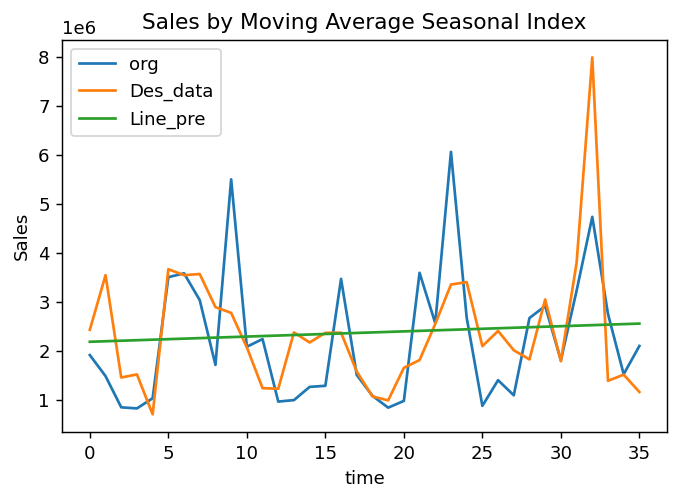

In [20]:
plt.plot(df_1['t'], df_1_ts3_MA_Result['orig'])
plt.plot(df_1['t'], df_1_ts3_MA_Result['Des_D'])
plt.plot(df_1['t'], des_pre_df_1_ts3_MA)
plt.legend(labels=['org', 'Des_data', 'Line_pre'])
plt.xlabel('time')
plt.ylabel('Sales')
plt.title('Sales by Moving Average Seasonal Index')
plt.show()

[ 0.19787847  1.08559265 -0.60200039 -0.55728696 -1.21091408  1.13076924
  1.0230638   1.03011096  0.48843741  0.3871208  -0.17174387 -0.82979986
 -0.84656292  0.04120008 -0.12642027  0.01804866  0.01236747 -0.61162631
 -1.0130069  -1.08500268 -0.57774924 -0.46296729  0.10248682  0.71976525
  0.75170479 -0.27648479 -0.04300436 -0.36102332 -0.51730916  0.43920572
 -0.56643237  1.01673011  4.36302667 -0.91906259 -0.83081728 -1.1296912 ]


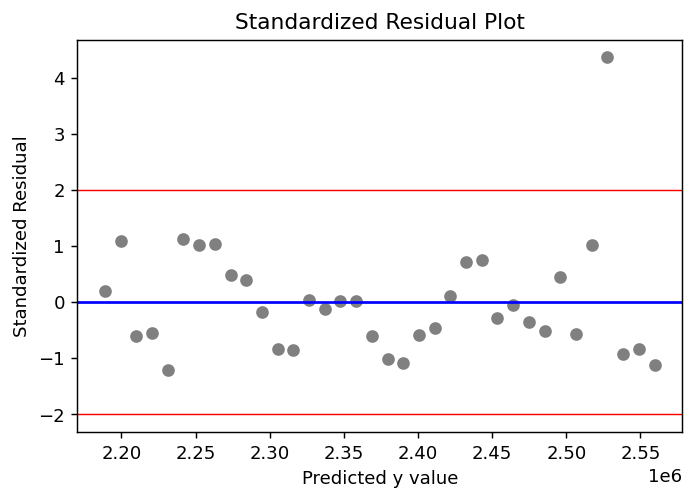

In [21]:
df_1_ts3_MA_st, df_1_ts3_MA_data, df_1_ts3_MA_ss2 = sso.summary_table(result_reg_df_1_ts3_MA, alpha=0.05)
df_1_ts3_MA_y_pre = df_1_ts3_MA_data[:, 2]
df_1_ts3_MA_SD = df_1_ts3_MA_data[:, 10]
print(df_1_ts3_MA_SD)
plt.plot(df_1_ts3_MA_y_pre, df_1_ts3_MA_SD, 'o', color = 'gray')
plt.axhline(y=2, color = 'red', lw = 0.8)
plt.axhline(y=0, color = 'blue')
plt.axhline(y=-2, color = 'red', lw = 0.8)
plt.title('Standardized Residual Plot')
plt.xlabel('Predicted y value')
plt.ylabel('Standardized Residual')
plt.show()

In [22]:
print('Shapiro Test')
stat, p = stats.shapiro(df_1_ts3_MA_SD)
print('Statistics=%.3f, p=%.3f' % (stat, p))
df_1_ts3_MA_SD_median = statistics.median(df_1_ts3_MA_SD)
#print('median = ', SD_median)
Z_pval = runsTest(df_1_ts3_MA_SD, df_1_ts3_MA_SD_median) 
print('p_value for Z-statistic= ', Z_pval)
print('\n')
print('The Durbin Watson test')
d_w = Durbin_Watson_test(df_1_ts3_MA_SD)
print('d value =', d_w)

Shapiro Test
Statistics=0.808, p=0.000
runs =  14
n1 =  18
n2 =  18
runs_exp =  19.0
stan_dev =  2.9568322818274866
z =  -1.6909988539863081
pval_z =  0.09083702152945593
p_value for Z-statistic=  0.09083702152945593


The Durbin Watson test
x_square_sum =  36.67482871939605
size =  36
x_d =  [ 0.          0.88771418 -1.68759304  0.04471343 -0.65362713  2.34168332
 -0.10770544  0.00704716 -0.54167356 -0.1013166  -0.55886467 -0.65805598
 -0.01676306  0.88776299 -0.16762035  0.14446894 -0.00568119 -0.62399378
 -0.40138059 -0.07199578  0.50725344  0.11478195  0.56545411  0.61727843
  0.03193954 -1.02818958  0.23348043 -0.31801896 -0.15628584  0.95651488
 -1.00563809  1.58316249  3.34629656 -5.28208926  0.08824531 -0.29887391]
d =  1.5771008430844435
d value = 1.5771008430844435
